# Obesity and City Composition
_IBM Applied Data Science Capstone Project Notebook_

Thanks for checking out my capstone project notebook. Feel free to [download the full report](https://github.com/amypeniston/Coursera_Capstone/blob/master/Capstone_Project_Report.pdf) associated with this code to learn more about my methodology and findings. You can also head over to [Medium](https://medium.com/@amypeniston/obesity-and-city-composition-exploring-the-impact-of-environmental-stimuli-e693e8af2046) to read a summary of my project in blog post format.

Note: if visualizations/maps do not load, please use this [alternative link](https://nbviewer.jupyter.org/github/amypeniston/Coursera_Capstone/blob/master/Capstone_Project_Notebook.ipynb?flush_cache=true) to view my Jupyter notebook.

---
#### Import Required Libraries

In [455]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import folium
import seaborn as sns
from bs4 import BeautifulSoup
from  geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
pd.set_option('display.max_colwidth',1000)

#### Import Foursquare & Mapquest developer credentials

In [355]:
%run "credentials.py"

#### Scrape obesity data

In [356]:
url_obesity_data = "https://www.stateofobesity.org/wp-json/state-of-obesity/v1/adult-obesity-data"
response = requests.get(url_obesity_data).json()

In [357]:
response_df = pd.DataFrame.from_dict(response)
response_df.head()

,ab,fips,st,yr1990,yr1990cnf,yr1990rnk,yr1995,yr1995cnf,yr1995rnk,yr2000,...,yr2014rnk,yr2015,yr2015cnf,yr2015rnk,yr2016,yr2016cnf,yr2016rnk,yr2017,yr2017cnf,yr2017rnk
0,AL,01,Alabama,11.2,1.0,21.0,15.7,1.1,17,22.6,...,5,35.6,1.5,2,35.7,1.6,3,36.3,1.6,5
1,AK,02,Alaska,NaN,NaN,NaN,15.7,1.5,17,20.9,...,24,29.8,2.4,26,31.4,2.9,20,34.2,2.9,9
2,AZ,04,Arizona,10.6,1.2,29.0,12.6,1.3,44,14.9,...,29,28.4,1.6,34,29.0,1.5,29,29.5,1.0,30
3,AR,05,Arkansas,NaN,NaN,NaN,17.0,1.2,5,21.9,...,1,34.5,2.3,6,35.7,2.4,3,35.0,2.4,7
4,CA,06,California,9.9,0.9,37.0,13.9,0.9,32,18.7,...,47,24.2,1.0,47,25.0,1.1,47,25.1,1.3,48


In [358]:
response_df.columns

Index(['ab', 'fips', 'st', 'yr1990', 'yr1990cnf', 'yr1990rnk', 'yr1995',
       'yr1995cnf', 'yr1995rnk', 'yr2000', 'yr2000cnf', 'yr2000rnk', 'yr2003',
       'yr2003cnf', 'yr2003rnk', 'yr2004', 'yr2004cnf', 'yr2004rnk', 'yr2005',
       'yr2005cnf', 'yr2005rnk', 'yr2006', 'yr2006cnf', 'yr2006rnk', 'yr2007',
       'yr2007cnf', 'yr2007rnk', 'yr2008', 'yr2008cnf', 'yr2008rnk', 'yr2009',
       'yr2009cnf', 'yr2009rnk', 'yr2010', 'yr2010cnf', 'yr2010rnk', 'yr2011',
       'yr2011cnf', 'yr2011rnk', 'yr2012', 'yr2012cnf', 'yr2012rnk', 'yr2013',
       'yr2013cnf', 'yr2013rnk', 'yr2014', 'yr2014cnf', 'yr2014rnk', 'yr2015',
       'yr2015cnf', 'yr2015rnk', 'yr2016', 'yr2016cnf', 'yr2016rnk', 'yr2017',
       'yr2017cnf', 'yr2017rnk'],
      dtype='object')

#### Process data to create nicely formatted dataframe

In [359]:
state_abbrevs = response_df[["ab", "st"]]

In [360]:
cols = ["st"]
for i in range(0, 18):
    if i not in [1, 2]:
        if i < 10:
            cols.append("yr200" + str(i))
        else:
            cols.append("yr20" + str(i))

obesity_rates_df = response_df[cols]
obesity_rates_df = obesity_rates_df.set_index("st")
obesity_rates_df.index.name = "State"
obesity_rates_df.columns = [col[-4:] for col in obesity_rates_df.columns]
obesity_rates_df.head()

,2000,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
State,,,,,,,,,,,,,,,,
Alabama,22.6,28.4,27.7,28.7,29.4,30.1,31.2,31.6,32.3,32.0,33.0,32.4,33.5,35.6,35.7,36.3
Alaska,20.9,23.5,23.5,24.9,25.8,27.3,27.2,26.9,25.9,27.4,25.7,28.4,29.7,29.8,31.4,34.2
Arizona,14.9,20.1,20.3,20.8,21.7,23.3,24.8,25.8,25.4,24.7,26.0,26.8,28.9,28.4,29.0,29.5
Arkansas,21.9,25.2,25.0,26.4,27.0,28.1,28.6,30.1,30.6,30.9,34.5,34.6,35.9,34.5,35.7,35.0
California,18.7,23.2,21.5,22.7,22.7,23.1,23.6,24.4,24.8,23.8,25.0,24.1,24.7,24.2,25.0,25.1


In [361]:
obesity_rates_df.describe()

,2000,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
count,51.000000,51.000000,50.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,19.103922,22.415686,22.528000,23.337255,24.225490,25.270588,25.984314,26.723529,27.178431,27.584314,27.945098,28.650980,29.225490,29.282353,29.792157,30.600000
std,2.390645,2.837349,2.604003,2.780285,2.804485,2.882450,2.904092,3.100619,3.214736,3.049483,3.375874,3.435076,3.416773,3.870850,3.738975,3.852012
min,14.500000,16.000000,16.400000,16.900000,17.600000,18.400000,18.900000,19.100000,19.800000,20.700000,20.500000,21.300000,21.300000,20.200000,22.300000,22.600000
25%,17.050000,20.200000,20.750000,21.600000,22.400000,23.300000,24.200000,25.050000,25.150000,25.200000,25.650000,26.350000,27.150000,26.200000,27.250000,27.900000
50%,19.400000,22.900000,22.600000,23.200000,24.400000,25.300000,26.000000,26.600000,27.100000,27.800000,27.600000,29.400000,29.600000,29.800000,29.900000,31.300000
75%,20.900000,24.450000,24.325000,25.300000,26.200000,27.350000,28.000000,29.000000,29.500000,29.600000,30.000000,31.050000,31.250000,31.550000,32.000000,33.100000
max,23.900000,28.400000,28.100000,29.500000,30.600000,31.700000,32.500000,33.800000,34.400000,34.900000,34.700000,35.100000,35.900000,36.200000,37.700000,38.100000


#### Examine obesity rate data on a national level

In [362]:
obesity_rates_df = obesity_rates_df.T
obesity_rates_df.index.name = "Year"
obesity_rates_df.head()

State,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Year,,,,,,,,,,,,,,,,,,,,,
2000,22.6,20.9,14.9,21.9,18.7,14.5,16.0,17.1,20.1,18.4,...,18.4,20.9,21.7,17.3,17.0,18.7,18.4,23.9,19.4,16.6
2003,28.4,23.5,20.1,25.2,23.2,16.0,19.1,24.0,20.3,19.9,...,22.9,25.0,24.6,20.8,19.6,21.7,21.7,27.7,20.9,20.1
2004,27.7,23.5,20.3,25.0,21.5,16.4,18.9,22.5,21.2,20.7,...,22.6,25.6,25.3,19.6,19.1,22.9,21.7,27.6,21.9,20.1
2005,28.7,24.9,20.8,26.4,22.7,16.9,19.6,22.8,21.5,21.8,...,24.0,26.6,25.8,20.8,19.5,23.3,22.4,28.6,22.9,21.7
2006,29.4,25.8,21.7,27.0,22.7,17.6,20.1,23.6,22.2,22.9,...,24.9,27.8,26.3,21.1,20.0,24.5,23.2,29.8,24.8,22.8


In [363]:
obesity_rates_df["National"] = obesity_rates_df.mean(axis=1)
obesity_rates_df = obesity_rates_df.reset_index()
obesity_rates_df.head()

State,Year,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,...,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,National
0,2000,22.6,20.9,14.9,21.9,18.7,14.5,16.0,17.1,20.1,...,20.9,21.7,17.3,17.0,18.7,18.4,23.9,19.4,16.6,19.103922
1,2003,28.4,23.5,20.1,25.2,23.2,16.0,19.1,24.0,20.3,...,25.0,24.6,20.8,19.6,21.7,21.7,27.7,20.9,20.1,22.415686
2,2004,27.7,23.5,20.3,25.0,21.5,16.4,18.9,22.5,21.2,...,25.6,25.3,19.6,19.1,22.9,21.7,27.6,21.9,20.1,22.528000
3,2005,28.7,24.9,20.8,26.4,22.7,16.9,19.6,22.8,21.5,...,26.6,25.8,20.8,19.5,23.3,22.4,28.6,22.9,21.7,23.337255
4,2006,29.4,25.8,21.7,27.0,22.7,17.6,20.1,23.6,22.2,...,27.8,26.3,21.1,20.0,24.5,23.2,29.8,24.8,22.8,24.225490


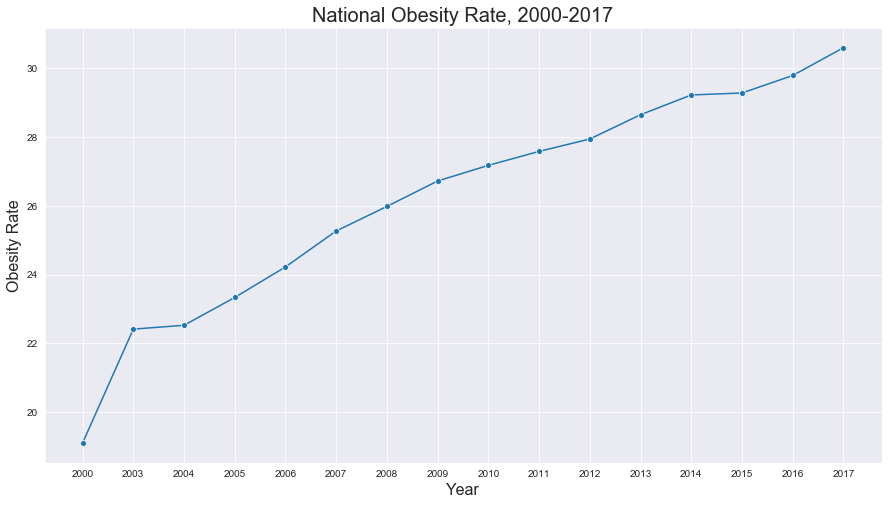

In [364]:
palette = sns.color_palette("mako_r", 6)
sns.set_style("darkgrid")
fig = plt.figure(figsize=(15,8))

sns.lineplot("Year", "National", data=obesity_rates_df, marker='o')
plt.title("National Obesity Rate, 2000-2017", fontsize=20)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Obesity Rate", fontsize=16)
plt.show()
# plt.savefig("figures/national-obesity-rate.png")

#### Examine obesity rate trends by state

In [365]:
map_df = obesity_rates_df.set_index("Year").T
map_df = map_df.reset_index()
map_df.columns.name = None
map_df.head()

,State,2000,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Alabama,22.6,28.4,27.7,28.7,29.4,30.1,31.2,31.6,32.3,32.0,33.0,32.4,33.5,35.6,35.7,36.3
1,Alaska,20.9,23.5,23.5,24.9,25.8,27.3,27.2,26.9,25.9,27.4,25.7,28.4,29.7,29.8,31.4,34.2
2,Arizona,14.9,20.1,20.3,20.8,21.7,23.3,24.8,25.8,25.4,24.7,26.0,26.8,28.9,28.4,29.0,29.5
3,Arkansas,21.9,25.2,25.0,26.4,27.0,28.1,28.6,30.1,30.6,30.9,34.5,34.6,35.9,34.5,35.7,35.0
4,California,18.7,23.2,21.5,22.7,22.7,23.1,23.6,24.4,24.8,23.8,25.0,24.1,24.7,24.2,25.0,25.1


In [366]:
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
states_geo = f'{url}/us-states.json'

states_map = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=states_geo,
    name='choropleth',
    data=map_df,
    columns=['State', '2017'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Obesity Rate (%)'
).add_to(states_map)

folium.LayerControl().add_to(states_map)

states_map

In [367]:
tidy_df = obesity_rates_df.iloc[:, :-1].melt(id_vars="Year")
tidy_df = tidy_df.rename(columns={"value": "Obesity_Rate"})
tidy_df.head()

,Year,State,Obesity_Rate
0,2000,Alabama,22.6
1,2003,Alabama,28.4
2,2004,Alabama,27.7
3,2005,Alabama,28.7
4,2006,Alabama,29.4


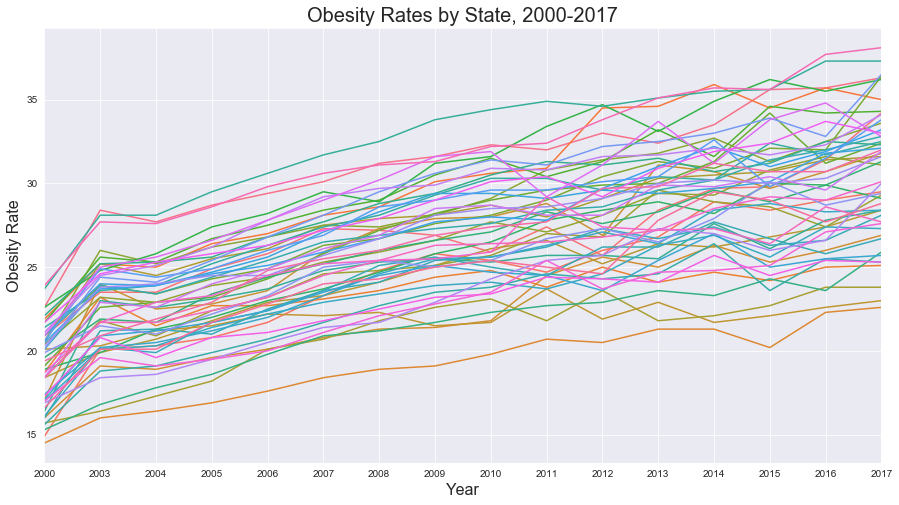

In [368]:
palette = sns.color_palette("mako_r", 6)
fig = plt.figure(figsize=(15,8))

sns.lineplot(x="Year", y="Obesity_Rate", hue="State", data=tidy_df, legend=False)
plt.title("Obesity Rates by State, 2000-2017", fontsize=20)
plt.xlim("2000", "2017")
plt.xlabel("Year", fontsize=16)
plt.ylabel("Obesity Rate", fontsize=16)
plt.show()
# plt.savefig("figures/state-obesity-rates.png")

#### Rank states based on 2017 obesity rate

In [369]:
map_df.head()

,State,2000,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Alabama,22.6,28.4,27.7,28.7,29.4,30.1,31.2,31.6,32.3,32.0,33.0,32.4,33.5,35.6,35.7,36.3
1,Alaska,20.9,23.5,23.5,24.9,25.8,27.3,27.2,26.9,25.9,27.4,25.7,28.4,29.7,29.8,31.4,34.2
2,Arizona,14.9,20.1,20.3,20.8,21.7,23.3,24.8,25.8,25.4,24.7,26.0,26.8,28.9,28.4,29.0,29.5
3,Arkansas,21.9,25.2,25.0,26.4,27.0,28.1,28.6,30.1,30.6,30.9,34.5,34.6,35.9,34.5,35.7,35.0
4,California,18.7,23.2,21.5,22.7,22.7,23.1,23.6,24.4,24.8,23.8,25.0,24.1,24.7,24.2,25.0,25.1


In [370]:
obesity_rates_2017 = map_df[["State", "2017"]].sort_values(by="2017", ascending=False).reset_index()
obesity_rates_2017["State Rank"] = obesity_rates_2017.index.values + 1
obesity_rates_2017 = obesity_rates_2017.drop(columns="index")
obesity_rates_2017 = obesity_rates_2017.rename(columns={"2017": "2017 Obesity Rate"})
obesity_rates_2017.head()

,State,2017 Obesity Rate,State Rank
0,West Virginia,38.1,1
1,Mississippi,37.3,2
2,Oklahoma,36.5,3
3,Iowa,36.4,4
4,Alabama,36.3,5


#### Scrape Wikipedia for capital cities for each state

In [371]:
url = "https://simple.wikipedia.org/wiki/List_of_U.S._state_capitals"

page = requests.get(url)
soup = BeautifulSoup(page.content, "html.parser")

table = soup.find(class_="wikitable")

data = []
for row in table.find_all("tr"):
    cells = row.find_all("td")
    if cells:
        data.append([cells[0].text.strip(),cells[3].text.strip()])

location_data_df = pd.DataFrame(data)
location_data_df.head()

,0,1
0,Alabama,Montgomery
1,Alaska,Juneau
2,Arizona,Phoenix
3,Arkansas,Little Rock
4,California,Sacramento


#### Construct dataframe with states, capital cities and state abbreviations

In [372]:
location_data_df = location_data_df.merge(state_abbrevs, how="inner", left_on=0, right_on="st")
location_data_df = location_data_df.drop("st", axis=1)
location_data_df.columns = ["State", "Capital City", "Abbreviation"]
location_data_df.head()

,State,Capital City,Abbreviation
0,Alabama,Montgomery,AL
1,Alaska,Juneau,AK
2,Arizona,Phoenix,AZ
3,Arkansas,Little Rock,AR
4,California,Sacramento,CA


#### Combine location data with 2017 obesity data
_Excludes District of Columbia_

In [373]:
obesity_rates_2017 = obesity_rates_2017.merge(location_data_df, how="inner", on="State")
cols = list(obesity_rates_2017.columns[0:1]) + list(obesity_rates_2017.columns[-2:]) + list(obesity_rates_2017.columns[1:-2])
obesity_rates_2017 = obesity_rates_2017[cols]
obesity_rates_2017.iloc[49,4] = 51
obesity_rates_2017.head()

,State,Capital City,Abbreviation,2017 Obesity Rate,State Rank
0,West Virginia,Charleston,WV,38.1,1
1,Mississippi,Jackson,MS,37.3,2
2,Oklahoma,Oklahoma City,OK,36.5,3
3,Iowa,Des Moines,IA,36.4,4
4,Alabama,Montgomery,AL,36.3,5


#### What are the most obese states?

In [374]:
obesity_rates_2017.iloc[0:5, :]

,State,Capital City,Abbreviation,2017 Obesity Rate,State Rank
0,West Virginia,Charleston,WV,38.1,1
1,Mississippi,Jackson,MS,37.3,2
2,Oklahoma,Oklahoma City,OK,36.5,3
3,Iowa,Des Moines,IA,36.4,4
4,Alabama,Montgomery,AL,36.3,5


#### What are the least obese states?

In [375]:
obesity_rates_2017.iloc[-5:, :]

,State,Capital City,Abbreviation,2017 Obesity Rate,State Rank
45,Utah,Salt Lake City,UT,25.3,47
46,Montana,Helena,MT,25.3,48
47,California,Sacramento,CA,25.1,49
48,Hawaii,Honolulu,HI,23.8,50
49,Colorado,Denver,CO,22.6,51


#### Get lat/lngs for each capital city
_This will enable us to plot cities on a map_

In [376]:
def geocode_cities(row):
    geolocator = Nominatim(user_agent="project")
    capital_city = row["Capital City"]
    abbrev = row["Abbreviation"]
    country ="US"
    loc = geolocator.geocode(capital_city +',' + abbrev + ',' + country, timeout=10)
    return [loc.latitude, loc.longitude]

In [377]:
# obesity_rates_2017.loc[:, "City Lat"], obesity_rates_2017.loc[:, "City Lng"] = zip(*obesity_rates_2017.apply(geocode_cities, axis=1).copy())
# obesity_rates_2017.to_csv("assets/city_lat_lng_backup.csv", index=False)
obesity_rates_2017 = pd.read_csv("assets/city_lat_lng_backup.csv")
obesity_rates_2017.head()

,State,2017 Obesity Rate,State Rank,Capital City,Abbreviation,City Lat,City Lng
0,West Virginia,38.1,1,Charleston,WV,38.350600,-81.633281
1,Mississippi,37.3,2,Jackson,MS,32.299038,-90.184769
2,Oklahoma,36.5,3,Oklahoma City,OK,35.472989,-97.517054
3,Iowa,36.4,4,Des Moines,IA,41.591064,-93.603715
4,Alabama,36.3,5,Montgomery,AL,32.366966,-86.300648


#### Scrape Zip-Codes.com for zipcode data for each capital city

In [378]:
base_url = "https://www.zip-codes.com/city/"

In [379]:
def get_zipcodes():
    data = []
    for idx, row in obesity_rates_2017.iterrows():
        city_clean = row["Capital City"].replace(" ", "-")
        url = base_url + row["Abbreviation"] + "-" + city_clean + ".asp"
      
        print("Scraping: {}".format(url))
        page = requests.get(url)
        soup = BeautifulSoup(page.content)
        table = soup.find(class_="statTable")
        row_index = 0
        for rows in table.find_all("tr"):
            if row_index != 0:
                cells = rows.find_all("td")
                data.append([row["State"], row["Abbreviation"], row["Capital City"], cells[0].text.strip(), cells[1].text.strip(), cells[2].text.strip(), cells[3].text.strip()])
            row_index += 1
            
    cols = ["State", "Abbreviation", "Capital City", "Zipcode", "Zipcode Type", "County", "Population"]
    zipcode_df = pd.DataFrame(data, columns=cols)
    zipcode_df["Zipcode"] = zipcode_df["Zipcode"].str.split(" ").str[2]
    return zipcode_df

In [380]:
# zipcode_df = get_zipcodes()
# zipcode_df.to_csv("assets/zipcode_df_first10.csv", index=False)
zipcode_df = pd.read_csv("assets/zipcode_df_all.csv")
zipcode_df["Zipcode"] = zipcode_df["Zipcode"].astype(str)
zipcode_df.head()

,State,Abbreviation,Capital City,Zipcode,Zipcode Type,County,Population
0,West Virginia,WV,Charleston,25301,Standard,Kanawha,"2,771"
1,West Virginia,WV,Charleston,25302,Standard,Kanawha,"15,078"
2,West Virginia,WV,Charleston,25303,Standard,Kanawha,"7,112"
3,West Virginia,WV,Charleston,25304,Standard,Kanawha,"8,773"
4,West Virginia,WV,Charleston,25305,Standard,Kanawha,0


In [381]:
zipcode_df.shape

(1682, 7)

In [382]:
print("Zipcode data gathered for {} states: \n\n{}".format(len(zipcode_df["State"].unique()), zipcode_df["State"].unique()))

Zipcode data gathered for 50 states: 

['West Virginia' 'Mississippi' 'Oklahoma' 'Iowa' 'Alabama' 'Louisiana'
 'Arkansas' 'Kentucky' 'Alaska' 'South Carolina' 'Ohio' 'Indiana'
 'North Dakota' 'Texas' 'Nebraska' 'Tennessee' 'Missouri' 'Kansas'
 'Michigan' 'North Carolina' 'Wisconsin' 'South Dakota' 'Delaware'
 'Georgia' 'Pennsylvania' 'Maryland' 'Illinois' 'Virginia' 'Rhode Island'
 'Arizona' 'Oregon' 'Idaho' 'Maine' 'Wyoming' 'Florida' 'New Mexico'
 'Minnesota' 'New Hampshire' 'Washington' 'Vermont' 'New Jersey'
 'Connecticut' 'Nevada' 'Massachusetts' 'New York' 'Utah' 'Montana'
 'California' 'Hawaii' 'Colorado']


#### Geocode zipcodes to get lat/lngs
_This will enable us to query Foursquare for location data for each zipcode_

In [385]:
mapquest_url = "http://www.mapquestapi.com/geocoding/v1/address?key=" + MAPQUEST_KEY

def geocode_zipcodes_openstreetmap(row):
    state_abbrev = row["Abbreviation"]
    country = "US"
    zipcode = row["Zipcode"]
    
    payload = json.dumps({"location": {"postalCode": zipcode, "state": state_abbrev, "country": country}})
    r = requests.post(mapquest_url, data=payload).json()

    lat = r["results"][0]["locations"][0]["latLng"]["lat"]
    lng = r["results"][0]["locations"][0]["latLng"]["lng"]
    
    return [lat, lng]

#### Batch geocoding into 100 row chunks to bypass rate limiting

In [386]:
bounds = np.append(np.arange(0, zipcode_df.shape[0], 100), zipcode_df.shape[0])
geocoded_zipcodes = pd.DataFrame()

In [387]:
# for n in range(len(bounds) - 1):
#     print("Geocoding rows {} thru {}".format(bounds[n],bounds[n+1]))
#     section = zipcode_df[bounds[n]:bounds[n+1]]
#     section.loc[bounds[n]:bounds[n+1], "Zipcode Lat"], section.loc[bounds[n]:bounds[n+1], "Zipcode Lng"] = zip(*section.apply(geocode_zipcodes_openstreetmap, axis=1).copy())
#     geocoded_zipcodes = geocoded_zipcodes.append(section)

In [388]:
# geocoded_zipcodes.to_csv("assets/zipcode_df_all_geocoded.csv", index=False)

In [389]:
zipcode_df = pd.read_csv("assets/zipcode_df_all_geocoded.csv")
zipcode_df["Zipcode"] = zipcode_df["Zipcode"].astype(str)
zipcode_df.head()

,State,Abbreviation,Capital City,Zipcode,Zipcode Type,County,Population,Zipcode Lat,Zipcode Lng
0,West Virginia,WV,Charleston,25301,Standard,Kanawha,"2,771",38.350865,-81.630309
1,West Virginia,WV,Charleston,25302,Standard,Kanawha,"15,078",38.382326,-81.610118
2,West Virginia,WV,Charleston,25303,Standard,Kanawha,"7,112",38.360301,-81.683803
3,West Virginia,WV,Charleston,25304,Standard,Kanawha,"8,773",38.312015,-81.592362
4,West Virginia,WV,Charleston,25305,Standard,Kanawha,0,38.336604,-81.611315


In [390]:
zipcode_df.shape

(1682, 9)

#### Examine rows with missing lat/lngs

In [391]:
zipcode_df[zipcode_df["Zipcode Lat"].isnull()]

,State,Abbreviation,Capital City,Zipcode,Zipcode Type,County,Population,Zipcode Lat,Zipcode Lng


#### Remove rows with missing lat/lngs

In [392]:
zipcode_df = zipcode_df.dropna()
zipcode_df[zipcode_df["Zipcode Lat"].isnull()]

,State,Abbreviation,Capital City,Zipcode,Zipcode Type,County,Population,Zipcode Lat,Zipcode Lng


#### Visualize zipcodes for one of the capital cities
_Enabling us to double check that geocoding was performed correctly_

In [393]:
def plot_locations(city_lat, city_lng, city_name, df):
    city_map = folium.Map(location=[city_lat, city_lng], zoom_start=11)

    folium.vector_layers.CircleMarker(
        [city_lat, city_lng],
        radius=5,
        color="red",
        fill=True,
        fill_color="red",
        fill_opacity=0.6,
        tooltip=city_name
    ).add_to(city_map)

    for lat, lng, label in zip(df["Zipcode Lat"], df["Zipcode Lng"], df["Zipcode"]):
        folium.vector_layers.CircleMarker(
            [lat, lng],
            radius=3,
            color="blue",
            fill=True,
            fill_color="red",
            fill_opacity=0.6,
            tooltip=label
        ).add_to(city_map)
        
    return city_map

In [394]:
example_city = obesity_rates_2017.iloc[15,:]
print("Visualizing zipcodes around {}, {}\n".format(example_city["Capital City"], example_city["State"]))
plot_locations(example_city["City Lat"], 
               example_city["City Lng"], 
               example_city["Capital City"], 
               zipcode_df[zipcode_df["State"] == example_city["State"]])

Visualizing zipcodes around Nashville, Tennessee



#### Utilize the Foursquare API to get nearby venues within a 5 mile radius of each zipcode centroid

In [395]:
radius = 8047 # Approx 5 miles
limit = 100

def get_nearby_venues(df):
    venues_list = []
    
    for lat, lng, label in zip(df["Zipcode Lat"], df["Zipcode Lng"], df["Zipcode"]): 
        url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID, CLIENT_SECRET, VERSION,
            lat, lng, 
            radius, limit)
        
        response = requests.get(url).json()["response"]
        
        if "groups" in response:
            results = response["groups"][0]["items"]

            venues_list.append([(
                label,
                lat,
                lng,
                venue["venue"]["name"],
                venue["venue"]["location"]["lat"],
                venue["venue"]["location"]["lng"],
                venue["venue"]["categories"][0]["name"]
            ) for venue in results])
    
    if len(venues_list[0]) >= 1:
        nearby_venues = pd.DataFrame([item for venue in venues_list for item in venue])
        nearby_venues.columns = ["Zipcode", "Zipcode Lat", "Zipcode Lng", 
                             "Venue Name", "Venue Lat", "Venue Lng", "Venue Category"]
        return nearby_venues
    else:
        return pd.DataFrame()

In [396]:
# TESTING QUOTA LIMITS

# url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
#             CLIENT_ID, CLIENT_SECRET, VERSION,
#             35.781295, -78.64166999999999,
#             radius, limit)
        
# response = requests.get(url)

# response.content

In [397]:
bounds = np.append(np.arange(0, zipcode_df.shape[0], 100), zipcode_df.shape[0])
bounds

array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200, 1300, 1400, 1500, 1600, 1682])

In [398]:
bounds = bounds[10:]
bounds

array([1000, 1100, 1200, 1300, 1400, 1500, 1600, 1682])

In [399]:
nearby_venues = pd.DataFrame()

#### Batch requests into 100 row chunks to bypass rate limiting
_Requests were made over multiple days due to Foursquare's daily request limit_

In [400]:
# for n in range(len(bounds) - 1):
#     print("Finding nearby venues for rows {} thru {}".format(bounds[n],bounds[n+1]))
#     section = zipcode_df[bounds[n]:bounds[n+1]]
#     section_nearby_venues = get_nearby_venues(section)
#     nearby_venues = nearby_venues.append(section_nearby_venues)

# nearby_venues.to_csv("assets/nearby_venues_.csv", index=False)

In [401]:
first_batch = pd.read_csv("assets/nearby_venues_0to600.csv")
second_batch = pd.read_csv("assets/nearby_venues_600to700.csv")
third_batch = pd.read_csv("assets/nearby_venues_700to800.csv")
fourth_batch = pd.read_csv("assets/nearby_venues_800to900.csv")
fifth_batch = pd.read_csv("assets/nearby_venues_1000to1682.csv")
first_batch.shape, second_batch.shape, third_batch.shape, fourth_batch.shape, fifth_batch.shape

((57774, 7), (19158, 7), (9828, 7), (9900, 7), (64237, 7))

In [402]:
nearby_venues = first_batch.append(second_batch).append(third_batch).append(fourth_batch).append(fifth_batch)
nearby_venues["Zipcode"] = nearby_venues["Zipcode"].astype(str)
nearby_venues.shape

(160897, 7)

#### Examine venue results

In [403]:
print("Retrieved {} nearby venues having {} unique categories from {} different zipcodes:\n".format(nearby_venues.shape[0], 
                                                                       len(nearby_venues["Venue Category"].unique()),
                                                                       len(nearby_venues["Zipcode"].unique())))
nearby_venues.head()

Retrieved 160897 nearby venues having 488 unique categories from 1678 different zipcodes:



,Zipcode,Zipcode Lat,Zipcode Lng,Venue Name,Venue Lat,Venue Lng,Venue Category
0,25301,38.350865,-81.630309,Capitol Market,38.352168,-81.627642,Farmers Market
1,25301,38.350865,-81.630309,Taylor Books,38.350434,-81.633937,Bookstore
2,25301,38.350865,-81.630309,Pies and Pints Pizzeria,38.350354,-81.634295,Pizza Place
3,25301,38.350865,-81.630309,Black Sheep Burritos & Brews,38.350571,-81.635611,Burrito Place
4,25301,38.350865,-81.630309,Ellen's Homemade Ice Cream,38.350439,-81.634221,Ice Cream Shop


#### How many zipcodes did not return any venues?

In [404]:
unique_zips = nearby_venues["Zipcode"].unique()
print("There are {} unique zipcodes with venues.".format(len(unique_zips)))

for idx, row in zipcode_df.iterrows():
    if row["Zipcode"] not in unique_zips:
        print("Missing zipcode {} | lat/lng ({}, {}) | dataframe row {}".format(row["Zipcode"], row["Zipcode Lat"], row["Zipcode Lng"], idx))

There are 1678 unique zipcodes with venues.
Missing zipcode 99811 | lat/lng (58.48, -134.15) | dataframe row 327
Missing zipcode 17111 | lat/lng (40.2684, -76.789804) | dataframe row 867
Missing zipcode 80123 | lat/lng (39.614202, -105.07056399999999) | dataframe row 1614
Missing zipcode 80243 | lat/lng (39.738453, -104.984853) | dataframe row 1655


#### How many venues were found in each zipcode?
_Maximum should be 100 as this was the limit set in the Foursquare API call_

In [405]:
num_venues = nearby_venues.groupby("Zipcode").count()["Venue Category"].to_frame().sort_values("Venue Category", ascending=False)
num_venues.index.name = "Zipcode"
num_venues.columns = ["Number of Venues"]
num_venues.describe()

,Number of Venues
count,1678.000000
mean,95.886174
std,15.811714
min,1.000000
25%,100.000000
50%,100.000000
75%,100.000000
max,100.000000


#### What are the most common venue categories overall?

In [406]:
nearby_venues["Venue Category"].value_counts()[0:10]

Coffee Shop            7303
Pizza Place            6766
American Restaurant    6496
Mexican Restaurant     5242
Bar                    4166
Sandwich Place         4136
Italian Restaurant     3830
Hotel                  3615
Park                   3598
Brewery                3351
Name: Venue Category, dtype: int64

#### What are the least common venue categories overall?

In [407]:
nearby_venues["Venue Category"].value_counts()[-10:]

Afghan Restaurant                           1
Travel Agency                               1
Residential Building (Apartment / Condo)    1
Track Stadium                               1
Hospital                                    1
Advertising Agency                          1
Indian Chinese Restaurant                   1
Board Shop                                  1
Shoe Repair                                 1
College Library                             1
Name: Venue Category, dtype: int64

#### One-hot encode venue category column

In [408]:
nearby_venues_onehot = pd.get_dummies(nearby_venues["Venue Category"])
nearby_venues_onehot["Zipcode"] = nearby_venues["Zipcode"]

cols = [nearby_venues_onehot.columns[-1]] + list(nearby_venues_onehot.columns.values[:-1])
nearby_venues_onehot = nearby_venues_onehot[cols]

nearby_venues_onehot.head()

,Zipcode,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,25301,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,25301,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,25301,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,25301,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,25301,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [409]:
nearby_venues_onehot.shape

(160897, 489)

#### Group by zipcode to get frequency of venue categories

In [410]:
nearby_venues_grouped_by_zipcode = nearby_venues_onehot.groupby("Zipcode").mean().reset_index()
nearby_venues_grouped_by_zipcode.head()

,Zipcode,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,12201,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.01,0.01,0.0,0.01,0.0,0.01,0.0,0.0
1,12202,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.01,0.01,0.0,0.01,0.0,0.01,0.0,0.0
2,12203,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.01,0.0,0.00,0.0,0.03,0.0,0.0
3,12204,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.02,0.01,0.0,0.00,0.0,0.01,0.0,0.0
4,12205,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.01,0.0,0.01,0.0,0.02,0.0,0.0


#### Create helper function to list most frequent venue categories for each zipcode

In [411]:
def get_top_categories(df, idx, start_col=1, num=5):
    top = df.iloc[idx, start_col:].T.reset_index()
    top.columns = ["Venue Category", "Frequency"]
    top = top.set_index("Venue Category")
    top["Frequency"] = top["Frequency"].astype(float)
    top = top.sort_values("Frequency", ascending=False).head(num)
    return top

In [412]:
top_num = 5
example_row = 30

example_zipcode = nearby_venues_grouped_by_zipcode.iloc[example_row,0]
print("Top {} categories for zipcode {}:\n".format(top_num, example_zipcode))
get_top_categories(nearby_venues_grouped_by_zipcode, example_row, top_num)

Top 5 categories for zipcode 12238:



,Frequency
Venue Category,
Pub,0.06
Café,0.05
Italian Restaurant,0.05
Coffee Shop,0.05
American Restaurant,0.05


#### Collate top venue categories for each zipcode

In [413]:
cols = ["Zipcode"]
endings = ["st", "nd", "rd"]

for i in range(10):
    if i < 3:
        cols.append(str(i + 1) + endings[i] + " Most Common Category")
    else:
        cols.append(str(i + 1) + "th Most Common Category")

top_categories_by_zipcode = pd.DataFrame(columns=cols)
top_categories_by_zipcode["Zipcode"] = nearby_venues_grouped_by_zipcode["Zipcode"]

In [414]:
for idx, row in top_categories_by_zipcode.iterrows():
    top_categories_by_zipcode.iloc[idx, 1:] = get_top_categories(nearby_venues_grouped_by_zipcode, idx, 1, 10).index.values

top_categories_by_zipcode.head()

,Zipcode,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,12201,Pub,Café,Coffee Shop,American Restaurant,Italian Restaurant,Pizza Place,Convenience Store,Theater,Deli / Bodega,Brewery
1,12202,Pub,American Restaurant,Café,Coffee Shop,Pizza Place,Theater,Ice Cream Shop,Brewery,Italian Restaurant,Diner
2,12203,American Restaurant,Italian Restaurant,Bar,Liquor Store,Shopping Mall,Ice Cream Shop,Hotel,Coffee Shop,Burger Joint,Yoga Studio
3,12204,Café,Pub,Brewery,Park,American Restaurant,Bar,Deli / Bodega,Bakery,Burger Joint,Coffee Shop
4,12205,American Restaurant,Coffee Shop,Shopping Mall,Hotel,Gym / Fitness Center,Bakery,Cosmetics Shop,Steakhouse,Italian Restaurant,Ice Cream Shop


In [415]:
zipcode_df.head()

,State,Abbreviation,Capital City,Zipcode,Zipcode Type,County,Population,Zipcode Lat,Zipcode Lng
0,West Virginia,WV,Charleston,25301,Standard,Kanawha,"2,771",38.350865,-81.630309
1,West Virginia,WV,Charleston,25302,Standard,Kanawha,"15,078",38.382326,-81.610118
2,West Virginia,WV,Charleston,25303,Standard,Kanawha,"7,112",38.360301,-81.683803
3,West Virginia,WV,Charleston,25304,Standard,Kanawha,"8,773",38.312015,-81.592362
4,West Virginia,WV,Charleston,25305,Standard,Kanawha,0,38.336604,-81.611315


#### Collate top venue categories for each city/state

In [416]:
nearby_venues_grouped_by_city = nearby_venues_grouped_by_zipcode.merge(zipcode_df, on="Zipcode")
nearby_venues_grouped_by_city = nearby_venues_grouped_by_city.drop(columns=["County", "Population", "Zipcode Lat", "Zipcode Lng", "Zipcode Type"])
nearby_venues_grouped_by_city = nearby_venues_grouped_by_city.groupby(["State", "Capital City"]).mean().reset_index()
nearby_venues_grouped_by_city.head()

,State,Capital City,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Alabama,Montgomery,0.000000,0.000909,0.0,0.0,0.0,0.0,0.000379,0.0,...,0.0,0.0,0.000000,0.008561,0.0000,0.016439,0.000000,0.000000,0.007879,0.0
1,Alaska,Juneau,0.000000,0.000000,0.0,0.0,0.0,0.0,0.006018,0.0,...,0.0,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.010270,0.0
2,Arizona,Phoenix,0.000267,0.002154,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.008267,0.002400,0.0000,0.001600,0.000274,0.001867,0.000400,0.0
3,Arkansas,Little Rock,0.001405,0.000956,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.007200,0.000000,0.0000,0.005600,0.001005,0.006400,0.001200,0.0
4,California,Sacramento,0.000220,0.000000,0.0,0.0,0.0,0.0,0.000525,0.0,...,0.0,0.0,0.000749,0.001900,0.0002,0.001200,0.000100,0.008000,0.000500,0.0


In [417]:
cols = ["State", "Capital City"]
endings = ["st", "nd", "rd"]

for i in range(10):
    if i < 3:
        cols.append(str(i + 1) + endings[i] + " Most Common Category")
    else:
        cols.append(str(i + 1) + "th Most Common Category")

top_categories_by_city = pd.DataFrame(columns=cols)
top_categories_by_city["State"], top_categories_by_city["Capital City"] = nearby_venues_grouped_by_city["State"], nearby_venues_grouped_by_city["Capital City"]

In [418]:
for idx, row in top_categories_by_city.iterrows():
    top_categories_by_city.iloc[idx, 2:] = get_top_categories(nearby_venues_grouped_by_city, idx, 2, 10).index.values

top_categories_by_city.head()

,State,Capital City,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,Alabama,Montgomery,Pizza Place,Grocery Store,Bar,Fast Food Restaurant,American Restaurant,Fried Chicken Joint,Mexican Restaurant,Deli / Bodega,Coffee Shop,Seafood Restaurant
1,Alaska,Juneau,Coffee Shop,Trail,Seafood Restaurant,Bar,Scenic Lookout,Hotel,Café,Pizza Place,American Restaurant,Boat or Ferry
2,Arizona,Phoenix,Pizza Place,Mexican Restaurant,Coffee Shop,American Restaurant,Hotel,Art Gallery,Sandwich Place,Burger Joint,Bar,Breakfast Spot
3,Arkansas,Little Rock,Pizza Place,Coffee Shop,Hotel,Mexican Restaurant,American Restaurant,Brewery,Fast Food Restaurant,Cajun / Creole Restaurant,Sandwich Place,Park
4,California,Sacramento,Coffee Shop,American Restaurant,Mexican Restaurant,Sandwich Place,Pizza Place,Park,Hotel,Movie Theater,New American Restaurant,Chinese Restaurant


#### What are the most common categories for the most obese cities/states?

In [419]:
most_obese_states = obesity_rates_2017.iloc[0:10, 0].to_list()

most_obese_states_categories = top_categories_by_city[top_categories_by_city["State"].isin(most_obese_states)]
most_obese_states_categories

,State,Capital City,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,Alabama,Montgomery,Pizza Place,Grocery Store,Bar,Fast Food Restaurant,American Restaurant,Fried Chicken Joint,Mexican Restaurant,Deli / Bodega,Coffee Shop,Seafood Restaurant
1,Alaska,Juneau,Coffee Shop,Trail,Seafood Restaurant,Bar,Scenic Lookout,Hotel,Café,Pizza Place,American Restaurant,Boat or Ferry
3,Arkansas,Little Rock,Pizza Place,Coffee Shop,Hotel,Mexican Restaurant,American Restaurant,Brewery,Fast Food Restaurant,Cajun / Creole Restaurant,Sandwich Place,Park
14,Iowa,Des Moines,Coffee Shop,Italian Restaurant,Brewery,Sushi Restaurant,Pizza Place,Grocery Store,American Restaurant,Hotel,New American Restaurant,Café
16,Kentucky,Frankfort,Fast Food Restaurant,Mexican Restaurant,Discount Store,Pizza Place,Sandwich Place,Pharmacy,Coffee Shop,Salon / Barbershop,Seafood Restaurant,History Museum
17,Louisiana,Baton Rouge,Cajun / Creole Restaurant,Fast Food Restaurant,Fried Chicken Joint,Seafood Restaurant,Sandwich Place,Coffee Shop,Mexican Restaurant,Bar,American Restaurant,Burger Joint
23,Mississippi,Jackson,Coffee Shop,Sandwich Place,Burger Joint,Fast Food Restaurant,American Restaurant,Seafood Restaurant,Bar,Discount Store,Hotel,Pizza Place
35,Oklahoma,Oklahoma City,American Restaurant,Burger Joint,Pizza Place,Coffee Shop,Sandwich Place,Mexican Restaurant,Hotel,Restaurant,Steakhouse,Brewery
39,South Carolina,Columbia,Coffee Shop,American Restaurant,Pizza Place,Burger Joint,Bar,Hotel,Sandwich Place,Café,Seafood Restaurant,Mexican Restaurant
47,West Virginia,Charleston,American Restaurant,Mexican Restaurant,Pharmacy,Pizza Place,Sandwich Place,Fast Food Restaurant,Park,Bakery,Comfort Food Restaurant,Bar


In [420]:
def count_fast_food(df):
    print("Does fast food appear in top 10 venue categories?\n")
    count_fast_food = 0
    count_rows = 0
    for idx, row in df.iterrows():
        i = 0
        for item in row:
            position = None
            if item == "Fast Food Restaurant":
                position = i - 1
                count_fast_food += 1
                print("{}: Fast Food Restaurant ranked {}.".format(row["State"], position))
                break
            if position == None and i == len(row) - 1:
                print("{}: No.".format(row["State"]))
            i += 1
        count_rows += 1
    print("\nFast food was in the top 10 venue categories for {} out of {} states.".format(count_fast_food, count_rows))

In [421]:
count_fast_food(most_obese_states_categories)

Does fast food appear in top 10 venue categories?

Alabama: Fast Food Restaurant ranked 4.
Alaska: No.
Arkansas: Fast Food Restaurant ranked 7.
Iowa: No.
Kentucky: Fast Food Restaurant ranked 1.
Louisiana: Fast Food Restaurant ranked 2.
Mississippi: Fast Food Restaurant ranked 4.
Oklahoma: No.
South Carolina: No.
West Virginia: Fast Food Restaurant ranked 6.

Fast food was in the top 10 venue categories for 6 out of 10 states.


#### What are the most common categories for the least obese cities/states?

In [422]:
least_obese_states = obesity_rates_2017.iloc[-10:, 0].to_list()

least_obese_states_categories = top_categories_by_city[top_categories_by_city["State"].isin(least_obese_states)]
least_obese_states_categories

,State,Capital City,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
4,California,Sacramento,Coffee Shop,American Restaurant,Mexican Restaurant,Sandwich Place,Pizza Place,Park,Hotel,Movie Theater,New American Restaurant,Chinese Restaurant
5,Colorado,Denver,American Restaurant,Coffee Shop,Mexican Restaurant,Brewery,Hotel,Sandwich Place,Italian Restaurant,Park,Breakfast Spot,Pizza Place
6,Connecticut,Hartford,Italian Restaurant,Pizza Place,Diner,Sushi Restaurant,Burger Joint,Fast Food Restaurant,Ice Cream Shop,Sandwich Place,Café,Pharmacy
10,Hawaii,Honolulu,Japanese Restaurant,Bakery,Seafood Restaurant,Café,Noodle House,Coffee Shop,Dessert Shop,Hawaiian Restaurant,Hotel,Pizza Place
20,Massachusetts,Boston,Pizza Place,American Restaurant,Mexican Restaurant,Deli / Bodega,BBQ Joint,Coffee Shop,Italian Restaurant,Convenience Store,Thai Restaurant,Chinese Restaurant
25,Montana,Helena,Coffee Shop,Café,Sandwich Place,American Restaurant,Hardware Store,Brewery,Italian Restaurant,Grocery Store,Restaurant,Hotel
27,Nevada,Carson City,Coffee Shop,Grocery Store,Fast Food Restaurant,Mexican Restaurant,Hardware Store,Pharmacy,Burger Joint,Furniture / Home Store,Convenience Store,Breakfast Spot
29,New Jersey,Trenton,Pizza Place,Italian Restaurant,Restaurant,Coffee Shop,Convenience Store,Diner,Bar,Farm,Sports Bar,Park
31,New York,Albany,Pub,American Restaurant,Coffee Shop,Italian Restaurant,Café,Pizza Place,Brewery,Deli / Bodega,Theater,Bar
43,Utah,Salt Lake City,Coffee Shop,Grocery Store,Bakery,Hotel,Sandwich Place,Pizza Place,Burger Joint,Bar,Italian Restaurant,Mexican Restaurant


In [423]:
count_fast_food(least_obese_states_categories)

Does fast food appear in top 10 venue categories?

California: No.
Colorado: No.
Connecticut: Fast Food Restaurant ranked 6.
Hawaii: No.
Massachusetts: No.
Montana: No.
Nevada: Fast Food Restaurant ranked 3.
New Jersey: No.
New York: No.
Utah: No.

Fast food was in the top 10 venue categories for 2 out of 10 states.


#### Explore the relationship between fast food/gyms and obesity

In [424]:
cols = ["State", "Capital City", "Gym", "Gym / Fitness Center", "Fast Food Restaurant"]

correlation_df = nearby_venues_grouped_by_city[cols]
correlation_df = correlation_df.merge(obesity_rates_2017[["State", "2017 Obesity Rate", "State Rank"]], how="inner", on="State")
correlation_df = correlation_df[list(correlation_df.columns[0:2]) + list(correlation_df.columns[-2:]) + list(correlation_df.columns[2:-2])]
correlation_df["Gym + Fitness"] = correlation_df["Gym"] + correlation_df["Gym / Fitness Center"]
correlation_df = correlation_df.drop(columns=["Gym", "Gym / Fitness Center"])

correlation_df.head()

,State,Capital City,2017 Obesity Rate,State Rank,Fast Food Restaurant,Gym + Fitness
0,Alabama,Montgomery,36.3,5,0.047169,0.025606
1,Alaska,Juneau,34.2,9,0.000000,0.000000
2,Arizona,Phoenix,29.5,31,0.013605,0.014290
3,Arkansas,Little Rock,35.0,7,0.025651,0.011805
4,California,Sacramento,25.1,49,0.004000,0.018945


#### Determine whether the frequency of fast food restaurant/gyms are correlated with obesity rate
_These results indicate that there is a very weak positive relationship between the frequency of fast food restaurants and obesity. On the other hand, there appears to be no correlation between the frequency of gyms and obesity._

In [425]:
correlation_df.corr()

,2017 Obesity Rate,State Rank,Fast Food Restaurant,Gym + Fitness
2017 Obesity Rate,1.000000,-0.989262,0.277398,0.105826
State Rank,-0.989262,1.000000,-0.278843,-0.121166
Fast Food Restaurant,0.277398,-0.278843,1.000000,0.025494
Gym + Fitness,0.105826,-0.121166,0.025494,1.000000


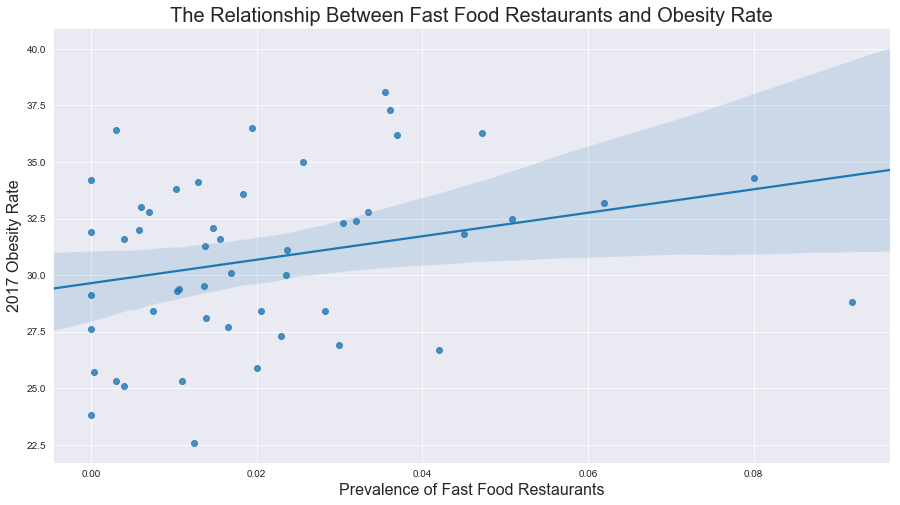

In [426]:
fig = plt.figure(figsize=(15,8))

sns.regplot(x="Fast Food Restaurant", y="2017 Obesity Rate", data=correlation_df)
plt.title("The Relationship Between Fast Food Restaurants and Obesity Rate", fontsize=20)
plt.xlabel("Prevalence of Fast Food Restaurants", fontsize=16)
plt.ylabel("2017 Obesity Rate", fontsize=16)
plt.show()

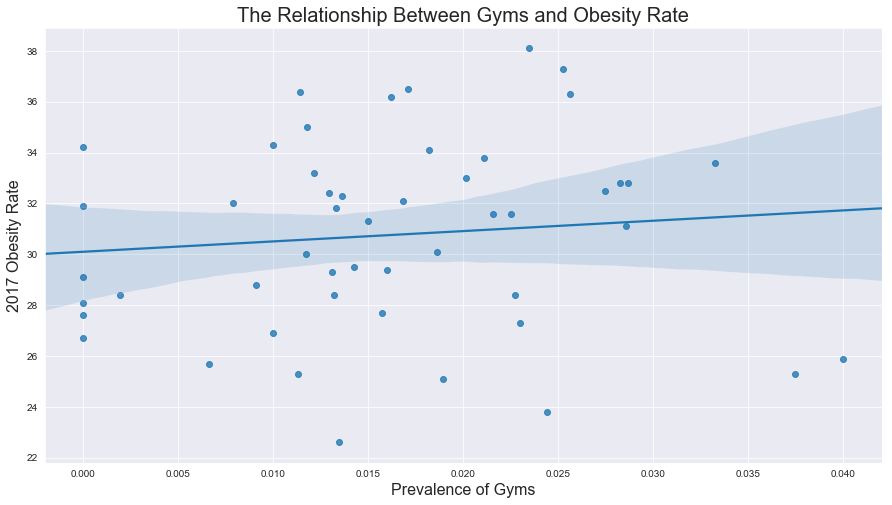

In [427]:
fig = plt.figure(figsize=(15,8))

sns.regplot(x="Gym + Fitness", y="2017 Obesity Rate", data=correlation_df)
plt.title("The Relationship Between Gyms and Obesity Rate", fontsize=20)
plt.xlabel("Prevalence of Gyms", fontsize=16)
plt.ylabel("2017 Obesity Rate", fontsize=16)
plt.show()

#### Assess whether a non-linear model might be a better fit
_Residual plots that vary with x suggest a non-linear relationship between variables. These plots, however, do not vary with x._

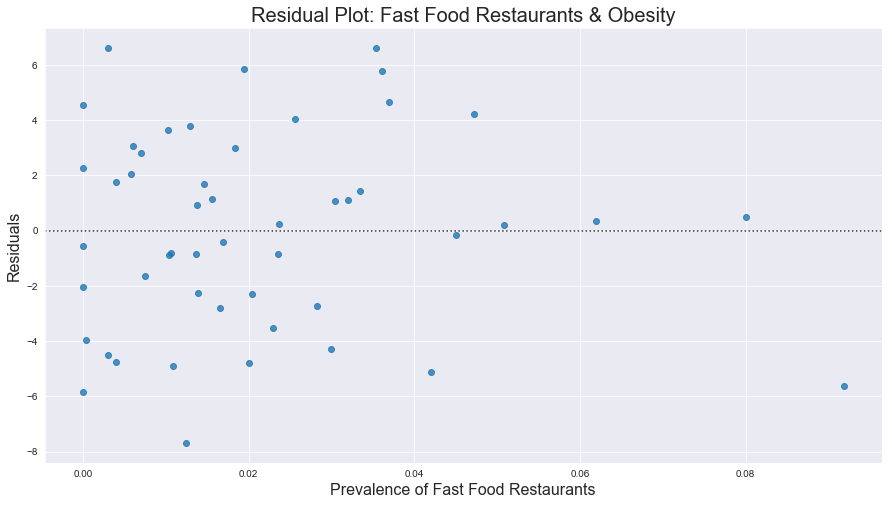

In [428]:
fig = plt.figure(figsize=(15,8))
x = correlation_df["Fast Food Restaurant"]
y = correlation_df["2017 Obesity Rate"]
sns.residplot(x, y)
plt.title("Residual Plot: Fast Food Restaurants & Obesity", fontsize=20)
plt.xlabel("Prevalence of Fast Food Restaurants", fontsize=16)
plt.ylabel("Residuals", fontsize=16)
plt.show()

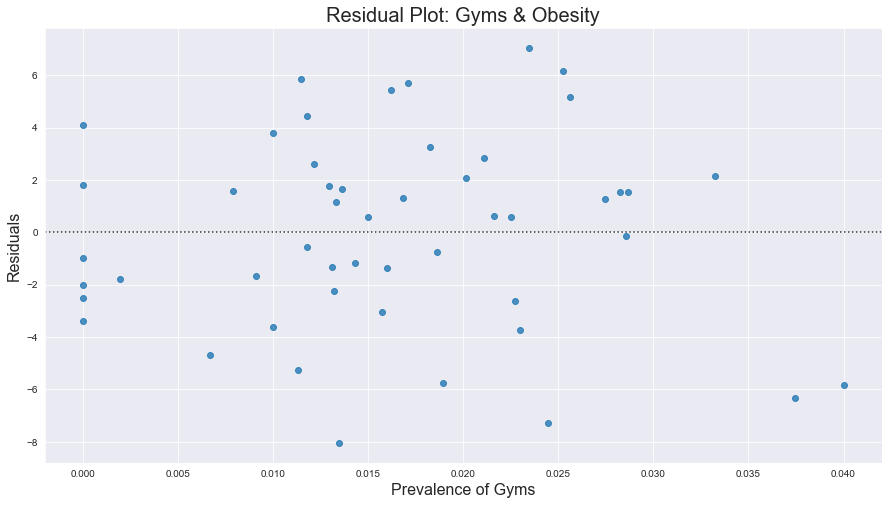

In [429]:
fig = plt.figure(figsize=(15,8))
x = correlation_df["Gym + Fitness"]
y = correlation_df["2017 Obesity Rate"]
sns.residplot(x, y)
plt.title("Residual Plot: Gyms & Obesity", fontsize=20)
plt.xlabel("Prevalence of Gyms", fontsize=16)
plt.ylabel("Residuals", fontsize=16)
plt.show()

#### Cluster cities using K-Means algorithm
_First, let's cluster using all venue categories_

In [499]:
clustering_df = nearby_venues_grouped_by_city.drop(columns=["State", "Capital City"])
clustering_df.head()

,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0.000000,0.000909,0.0,0.0,0.0,0.0,0.000379,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.008561,0.0000,0.016439,0.000000,0.000000,0.007879,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.006018,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.010270,0.0
2,0.000267,0.002154,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000267,...,0.0,0.0,0.008267,0.002400,0.0000,0.001600,0.000274,0.001867,0.000400,0.0
3,0.001405,0.000956,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.007200,0.000000,0.0000,0.005600,0.001005,0.006400,0.001200,0.0
4,0.000220,0.000000,0.0,0.0,0.0,0.0,0.000525,0.0,0.0,0.000000,...,0.0,0.0,0.000749,0.001900,0.0002,0.001200,0.000100,0.008000,0.000500,0.0


#### Use elbow method to determine whether there is an optimal number of clusters

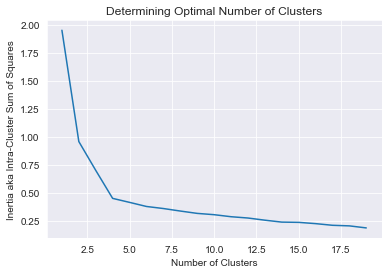

In [500]:
scores = []
cluster_range = range(1, 20)

for k in cluster_range:
    km = KMeans(n_clusters=k)
    km.fit(clustering_df)
    scores.append(km.inertia_)
    
plt.title("Determining Optimal Number of Clusters")
plt.plot(cluster_range, scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia aka Intra-Cluster Sum of Squares")
plt.show()

#### The "elbow" of the curve occurs at number of clusters equals 4

In [501]:
optimal_clusters = 4
k_means = KMeans(n_clusters=optimal_clusters, random_state=0)
k_means.fit(clustering_df)
clusters = k_means.labels_
clusters[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

#### Merge cluster results with top categories by city/state dataframe

In [502]:
cluster_results = pd.DataFrame()

In [503]:
cluster_results = top_categories_by_city.copy()
cluster_results.insert(2, "Cluster", clusters)
cluster_results.head()

,State,Capital City,Cluster,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,Alabama,Montgomery,0,Pizza Place,Grocery Store,Bar,Fast Food Restaurant,American Restaurant,Fried Chicken Joint,Mexican Restaurant,Deli / Bodega,Coffee Shop,Seafood Restaurant
1,Alaska,Juneau,0,Coffee Shop,Trail,Seafood Restaurant,Bar,Scenic Lookout,Hotel,Café,Pizza Place,American Restaurant,Boat or Ferry
2,Arizona,Phoenix,0,Pizza Place,Mexican Restaurant,Coffee Shop,American Restaurant,Hotel,Art Gallery,Sandwich Place,Burger Joint,Bar,Breakfast Spot
3,Arkansas,Little Rock,0,Pizza Place,Coffee Shop,Hotel,Mexican Restaurant,American Restaurant,Brewery,Fast Food Restaurant,Cajun / Creole Restaurant,Sandwich Place,Park
4,California,Sacramento,0,Coffee Shop,American Restaurant,Mexican Restaurant,Sandwich Place,Pizza Place,Park,Hotel,Movie Theater,New American Restaurant,Chinese Restaurant


In [504]:
obesity_rates_2017.head()

,State,2017 Obesity Rate,State Rank,Capital City,Abbreviation,City Lat,City Lng
0,West Virginia,38.1,1,Charleston,WV,38.350600,-81.633281
1,Mississippi,37.3,2,Jackson,MS,32.299038,-90.184769
2,Oklahoma,36.5,3,Oklahoma City,OK,35.472989,-97.517054
3,Iowa,36.4,4,Des Moines,IA,41.591064,-93.603715
4,Alabama,36.3,5,Montgomery,AL,32.366966,-86.300648


In [505]:
cluster_results = cluster_results.merge(obesity_rates_2017[["State", "2017 Obesity Rate", "State Rank", "Abbreviation", "City Lat", "City Lng"]], how="inner", on="State")
cluster_results.head()

,State,Capital City,Cluster,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category,2017 Obesity Rate,State Rank,Abbreviation,City Lat,City Lng
0,Alabama,Montgomery,0,Pizza Place,Grocery Store,Bar,Fast Food Restaurant,American Restaurant,Fried Chicken Joint,Mexican Restaurant,Deli / Bodega,Coffee Shop,Seafood Restaurant,36.3,5,AL,32.366966,-86.300648
1,Alaska,Juneau,0,Coffee Shop,Trail,Seafood Restaurant,Bar,Scenic Lookout,Hotel,Café,Pizza Place,American Restaurant,Boat or Ferry,34.2,9,AK,58.301950,-134.419734
2,Arizona,Phoenix,0,Pizza Place,Mexican Restaurant,Coffee Shop,American Restaurant,Hotel,Art Gallery,Sandwich Place,Burger Joint,Bar,Breakfast Spot,29.5,31,AZ,33.448587,-112.077346
3,Arkansas,Little Rock,0,Pizza Place,Coffee Shop,Hotel,Mexican Restaurant,American Restaurant,Brewery,Fast Food Restaurant,Cajun / Creole Restaurant,Sandwich Place,Park,35.0,7,AR,34.746481,-92.289595
4,California,Sacramento,0,Coffee Shop,American Restaurant,Mexican Restaurant,Sandwich Place,Pizza Place,Park,Hotel,Movie Theater,New American Restaurant,Chinese Restaurant,25.1,49,CA,38.581572,-121.494400


In [506]:
cols = cluster_results.columns.values
new_cols = list(cols[0:2]) + list(cols[-5:]) + list(cols[2:-5])
cluster_results = cluster_results[new_cols]
cluster_results.head()

,State,Capital City,2017 Obesity Rate,State Rank,Abbreviation,City Lat,City Lng,Cluster,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,Alabama,Montgomery,36.3,5,AL,32.366966,-86.300648,0,Pizza Place,Grocery Store,Bar,Fast Food Restaurant,American Restaurant,Fried Chicken Joint,Mexican Restaurant,Deli / Bodega,Coffee Shop,Seafood Restaurant
1,Alaska,Juneau,34.2,9,AK,58.301950,-134.419734,0,Coffee Shop,Trail,Seafood Restaurant,Bar,Scenic Lookout,Hotel,Café,Pizza Place,American Restaurant,Boat or Ferry
2,Arizona,Phoenix,29.5,31,AZ,33.448587,-112.077346,0,Pizza Place,Mexican Restaurant,Coffee Shop,American Restaurant,Hotel,Art Gallery,Sandwich Place,Burger Joint,Bar,Breakfast Spot
3,Arkansas,Little Rock,35.0,7,AR,34.746481,-92.289595,0,Pizza Place,Coffee Shop,Hotel,Mexican Restaurant,American Restaurant,Brewery,Fast Food Restaurant,Cajun / Creole Restaurant,Sandwich Place,Park
4,California,Sacramento,25.1,49,CA,38.581572,-121.494400,0,Coffee Shop,American Restaurant,Mexican Restaurant,Sandwich Place,Pizza Place,Park,Hotel,Movie Theater,New American Restaurant,Chinese Restaurant


#### Visualize clusters

In [507]:
cluster_map = folium.Map(location=[48, -102], zoom_start=3)
                         
x = np.arange(optimal_clusters)
colors_array = cm.rainbow(np.linspace(0, .8, len(x)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lng, state, city, cluster, obesity_rate in zip(cluster_results["City Lat"], cluster_results["City Lng"], 
                                          cluster_results["State"], cluster_results["Capital City"], 
                                          cluster_results["Cluster"], cluster_results["2017 Obesity Rate"]):
    label = "{}: {} (Cluster {}, Obesity Rate {})".format(city, state, cluster, obesity_rate)
    folium.vector_layers.CircleMarker(
        [lat, lng],
        radius=5,
        fill=True,
        color=rainbow[cluster],
        fill_color=rainbow[cluster],
        fill_opacity=0.6,
        tooltip=label
    ).add_to(cluster_map)

cluster_map

#### Examine clusters: average obesity rate & state rank

In [508]:
def cluster_summary(cluster_results, optimal_clusters):
    data = []
    for i in range(0, optimal_clusters):
        states = list(cluster_results[cluster_results["Cluster"] == i]["State"])
        num_states = len(states)
        state_ranks = list(cluster_results[cluster_results["Cluster"] == i]["State Rank"])

        states_with_ranks = ["{} ({})".format(s, r) for s, r in zip(states, state_ranks)]

        avg_obesity_rate = round(cluster_results[cluster_results["Cluster"] == i]["2017 Obesity Rate"].mean(), 2)
        avg_state_rank = round(cluster_results[cluster_results["Cluster"] == i]["State Rank"].mean())

        # print("Cluster {} - {} States - {}:\n - Avg state obesity rank = {}\n - Avg 2017 obesity rate = {}\n".format(i, num_states, states_with_ranks, avg_state_rank, avg_obesity_rate, avg_fast_food_frequency))
        data.append([i, avg_obesity_rate, avg_state_rank, num_states, states_with_ranks])
    cluster_summary = pd.DataFrame(data)
    cluster_summary.columns = ["Cluster", "Avg Obesity Rate", "Avg State Rank", "# States", "States (Rank)"]
    return cluster_summary

In [509]:
summary = cluster_summary(cluster_results, optimal_clusters)

#### Since Vermont, Maine and South Dakota appear to be outliers, let's cluster again excluding these states

In [510]:
clustering_df_ex_states = nearby_venues_grouped_by_city[np.logical_not(nearby_venues_grouped_by_city["State"].
                                                                   isin(["Vermont","Maine", "South Dakota"]))].drop(columns=["State", "Capital City"])
clustering_df_ex_states.head()

,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0.000000,0.000909,0.0,0.0,0.0,0.0,0.000379,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.008561,0.0000,0.016439,0.000000,0.000000,0.007879,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.006018,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.010270,0.0
2,0.000267,0.002154,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000267,...,0.0,0.0,0.008267,0.002400,0.0000,0.001600,0.000274,0.001867,0.000400,0.0
3,0.001405,0.000956,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.007200,0.000000,0.0000,0.005600,0.001005,0.006400,0.001200,0.0
4,0.000220,0.000000,0.0,0.0,0.0,0.0,0.000525,0.0,0.0,0.000000,...,0.0,0.0,0.000749,0.001900,0.0002,0.001200,0.000100,0.008000,0.000500,0.0


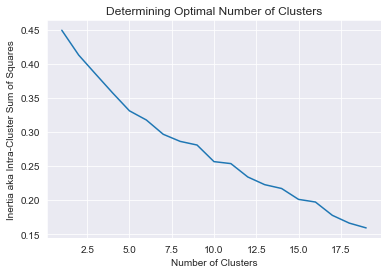

In [511]:
scores = []
cluster_range = range(1, 20)

for k in cluster_range:
    km = KMeans(n_clusters=k)
    km.fit(clustering_df_ex_states)
    scores.append(km.inertia_)
    
plt.title("Determining Optimal Number of Clusters")
plt.plot(cluster_range, scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia aka Intra-Cluster Sum of Squares")
plt.show()

#### No optimal number of clusters detected

In [512]:
optimal_clusters = 2
k_means = KMeans(n_clusters=optimal_clusters, random_state=0)
k_means.fit(clustering_df_ex_vt)
clusters = k_means.labels_

cluster_results = pd.DataFrame()
cluster_results = top_categories_by_city[np.logical_not(top_categories_by_city["State"].
                                                                   isin(["Vermont","Maine", "South Dakota"]))].copy()
cluster_results.insert(2, "Cluster", clusters)

cluster_results = cluster_results.merge(obesity_rates_2017[["State", "2017 Obesity Rate", "State Rank", "Abbreviation", "City Lat", "City Lng"]], how="inner", on="State")

cols = cluster_results.columns.values
new_cols = list(cols[0:2]) + list(cols[-5:]) + list(cols[2:-5])
cluster_results = cluster_results[new_cols]


#### Visualize clusters

In [513]:
cluster_map = folium.Map(location=[48, -102], zoom_start=3)
                         
x = np.arange(optimal_clusters)
colors_array = cm.rainbow(np.linspace(0, .8, len(x)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lng, state, city, cluster, obesity_rate in zip(cluster_results["City Lat"], cluster_results["City Lng"], 
                                          cluster_results["State"], cluster_results["Capital City"], 
                                          cluster_results["Cluster"], cluster_results["2017 Obesity Rate"]):
    label = "{}: {} (Cluster {}, Obesity Rate {})".format(city, state, cluster, obesity_rate)
    folium.vector_layers.CircleMarker(
        [lat, lng],
        radius=5,
        fill=True,
        color=rainbow[cluster],
        fill_color=rainbow[cluster],
        fill_opacity=0.6,
        tooltip=label
    ).add_to(cluster_map)

cluster_map

#### Examine clusters: average obesity rate & state rank

In [514]:
summary = cluster_summary(cluster_results, optimal_clusters)
summary

,Cluster,Avg Obesity Rate,Avg State Rank,# States,States (Rank)
0,0,31.94,22,20,"[Alabama (5), Connecticut (43), Delaware (23), Florida (36), Illinois (27), Kansas (18), Kentucky (8), Louisiana (6), Massachusetts (45), Michigan (19), Mississippi (2), Missouri (17), Nebraska (15), Nevada (44), New Jersey (42), North Dakota (13), Oklahoma (3), Rhode Island (30), West Virginia (1), Wyoming (35)]"
1,1,30.01,29,27,"[Alaska (9), Arizona (31), Arkansas (7), California (49), Colorado (52), Georgia (24), Hawaii (50), Idaho (33), Indiana (12), Iowa (4), Maryland (26), Minnesota (38), Montana (48), New Hampshire (39), New Mexico (37), New York (46), North Carolina (20), Ohio (11), Oregon (32), Pennsylvania (25), South Carolina (10), Tennessee (16), Texas (14), Utah (47), Virginia (29), Washington (40), Wisconsin (21)]"


#### How does the difference in average obesity rates between clusters compare to our entire dataset?

**What is the percentage difference between the highest and lowest obesity rates in 2017?**

In [515]:
highest_obesity_rate_2017 = obesity_rates_2017.iloc[0,1]
lowest_obesity_rate_2017 = obesity_rates_2017.iloc[-1,1]

percentage_difference_highest_lowest = highest_obesity_rate_2017/lowest_obesity_rate_2017 -1
percentage_difference_highest_lowest

0.6858407079646018

**What is the percentage difference between the obesity rates of the clusters?**

In [516]:
summary.iloc[0,1]/summary.iloc[-1,1] - 1

0.06431189603465515

#### Cluster cities again, this time using only specific venue categories

In [517]:
clustering_df_specific = clustering_df_ex_states[["Fast Food Restaurant", "Gym", "Gym / Fitness Center",
                                        "Trail", "Recreation Center", "Grocery Store", "Supermarket", 
                                        "Health Food Store"]]
clustering_df_specific.head()

,Fast Food Restaurant,Gym,Gym / Fitness Center,Trail,Recreation Center,Grocery Store,Supermarket,Health Food Store
0,0.047169,0.021364,0.004242,0.000000,0.007576,0.052135,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.059357,0.000000,0.020294,0.006018,0.000000
2,0.013605,0.005430,0.008860,0.014179,0.000000,0.017940,0.002133,0.001467
3,0.025651,0.002000,0.009805,0.005808,0.000000,0.004883,0.006860,0.000000
4,0.004000,0.016600,0.002345,0.000700,0.000100,0.012061,0.003623,0.000600


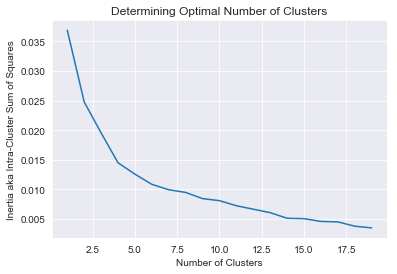

In [518]:
scores = []
cluster_range = range(1, 20)

for k in cluster_range:
    km = KMeans(n_clusters=k)
    km.fit(clustering_df_specific)
    scores.append(km.inertia_)
    
plt.title("Determining Optimal Number of Clusters")
plt.plot(cluster_range, scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia aka Intra-Cluster Sum of Squares")
plt.show()

#### No optimal number of clusters detected

In [519]:
optimal_clusters = 2
k_means = KMeans(n_clusters=optimal_clusters, random_state=0)
k_means.fit(clustering_df_specific)
clusters = k_means.labels_

cluster_results = pd.DataFrame()
cluster_results = top_categories_by_city[np.logical_not(top_categories_by_city["State"].
                                                                   isin(["Vermont","Maine", "South Dakota"]))].copy()
cluster_results.insert(2, "Cluster", clusters)

cluster_results = cluster_results.merge(obesity_rates_2017[["State", "2017 Obesity Rate", "State Rank", "Abbreviation", "City Lat", "City Lng"]], how="inner", on="State")

cols = cluster_results.columns.values
new_cols = list(cols[0:2]) + list(cols[-5:]) + list(cols[2:-5])
cluster_results = cluster_results[new_cols]

#### Visualize clusters

In [520]:
cluster_map = folium.Map(location=[48, -102], zoom_start=3)
                         
x = np.arange(optimal_clusters)
colors_array = cm.rainbow(np.linspace(0, .8, len(x)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lng, state, city, cluster, obesity_rate in zip(cluster_results["City Lat"], cluster_results["City Lng"], 
                                          cluster_results["State"], cluster_results["Capital City"], 
                                          cluster_results["Cluster"], cluster_results["2017 Obesity Rate"]):
    label = "{}: {} (Cluster {}, Obesity Rate {})".format(city, state, cluster, obesity_rate)
    folium.vector_layers.CircleMarker(
        [lat, lng],
        radius=5,
        fill=True,
        color=rainbow[cluster],
        fill_color=rainbow[cluster],
        fill_opacity=0.6,
        tooltip=label
    ).add_to(cluster_map)

cluster_map

#### Visualize clusters in relation to state obesity choropleth

In [521]:
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
states_geo = f'{url}/us-states.json'

states_clusters_map = folium.Map(location=[48, -102], zoom_start=3)


folium.Choropleth(
    geo_data=states_geo,
    name='choropleth',
    data=map_df,
    columns=['State', '2017'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Obesity Rate (%)'
).add_to(states_clusters_map)
    
    
x = np.arange(optimal_clusters)
colors_array = cm.rainbow(np.linspace(0, .8, len(x)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lng, state, city, cluster, obesity_rate in zip(cluster_results["City Lat"], cluster_results["City Lng"], 
                                          cluster_results["State"], cluster_results["Capital City"], 
                                          cluster_results["Cluster"], cluster_results["2017 Obesity Rate"]):
    label = "{}: {} (Cluster {}, Obesity Rate {})".format(city, state, cluster, obesity_rate)
    folium.vector_layers.CircleMarker(
        [lat, lng],
        radius=5,
        fill=True,
        color=rainbow[cluster],
        fill_color=rainbow[cluster],
        fill_opacity=0.6,
        tooltip=label
    ).add_to(states_clusters_map)

folium.LayerControl().add_to(states_clusters_map)
states_clusters_map

#### Examine clusters: average obesity rate & state rank

In [523]:
summary = cluster_summary(cluster_results, optimal_clusters)
summary

,Cluster,Avg Obesity Rate,Avg State Rank,# States,States (Rank)
0,0,33.45,15,11,"[Alabama (5), Delaware (23), Kentucky (8), Louisiana (6), Mississippi (2), Missouri (17), Nebraska (15), Nevada (44), North Dakota (13), West Virginia (1), Wyoming (35)]"
1,1,30.03,29,36,"[Alaska (9), Arizona (31), Arkansas (7), California (49), Colorado (52), Connecticut (43), Florida (36), Georgia (24), Hawaii (50), Idaho (33), Illinois (27), Indiana (12), Iowa (4), Kansas (18), Maryland (26), Massachusetts (45), Michigan (19), Minnesota (38), Montana (48), New Hampshire (39), New Jersey (42), New Mexico (37), New York (46), North Carolina (20), Ohio (11), Oklahoma (3), Oregon (32), Pennsylvania (25), Rhode Island (30), South Carolina (10), Tennessee (16), Texas (14), Utah (47), Virginia (29), Washington (40), Wisconsin (21)]"


#### How does the difference in average obesity rates between clusters compare to our entire dataset?

**What is the percentage difference between the highest and lowest obesity rates in 2017?**

In [524]:
percentage_difference_highest_lowest

0.6858407079646018

**What is the percentage difference between the obesity rates of the clusters?**

In [526]:
summary.iloc[0,1]/summary.iloc[-1,1] - 1

0.11388611388611403

#### Thanks for reading! Please use the links below to view the full report or blog post associated with this notebook:

* [Obesity and City Composition - Report](https://github.com/amypeniston/Coursera_Capstone/blob/master/Capstone_Project_Report.pdf)
* [Exploring the Relationship between Obesity and City Compositon - Blog Post](https://medium.com/@amypeniston/obesity-and-city-composition-exploring-the-impact-of-environmental-stimuli-e693e8af2046)